In [1]:
import tensorflow as tf
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import glob 
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0)

#convert dataframe to python list
rhineLevelvalues = df.values.tolist()
rhineLevel = [i[0] for i in rhineLevelvalues]

df

,level
date,
2016-01-01,75
2016-01-02,74
2016-01-03,80
2016-01-04,89
2016-01-05,108
...,...
2020-06-03,103
2020-06-04,101
2020-06-05,107


# 1. Autoregression Models

Autoregression is a time series model that uses observations from previous time steps as input
to a regression equation to predict the value at the next time step. It is a very simple idea
that can result in accurate forecasts on a range of time series problems. We're going to find out how it suits our problem.

As first steps we are going to explore some simple correlation plots.
### 1.1. Quick Check for Autocorrelation

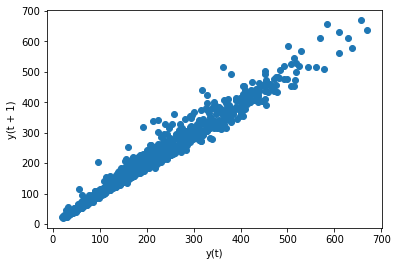

In [5]:
# lag plot of time series
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import lag_plot

df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0)
lag_plot(df)
pyplot.show()

Running the example plots the Rhine level (t + 1) on the y-axis against the Rhine level
on the previous day (t) on the x-axis. We can see a large ball of observations along a diagonal line of the plot. It clearly shows a
relationship or some correlation. This process could be repeated for any other lagged observation,
such as if we wanted to review the relationship with the last 7 days or with the same day last
month or last year. Another quick check that we can do is to directly calculate the correlation
between the observation and the lag variable.

Another quick check that we can do is to directly calculate the correlation
between the observation and the lag variable.
We can use a statistical test like the *Pearson’s correlation coefficient*. This produces a
number to summarize how correlated two variables are between -1 (negatively correlated) and
+1 (positively correlated) with small values close to zero indicating low correlation and high
values above 0.5 or below -0.5 showing high correlation.
Correlation can be calculated easily using the corr() function2 on the DataFrame of the
lagged dataset. The example below creates a lagged version of the Rhine level
dataset and calculates a correlation matrix of each column with other columns, including itself.

In [10]:
# correlation of lag=1
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)
values = DataFrame(df.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

            t       t+1
t    1.000000  0.983826
t+1  0.983826  1.000000


Once again we see a high correlation among the first lag; this is a good confirmation for the plot above. It shows a strong positive correlation (0.98)
between the observation and the lag=1 value.

This is good for one-off checks, but tedious if we want to check a large number of lag variables
in our time series. Next, we will look at a scaled-up version of this approach.

## 1.2. Autocorrelation Plots

We can plot the correlation coefficient for each lag variable. This can very quickly give an
idea of which lag variables may be good candidates for use in a predictive model and how
the relationship between the observation and its historic values changes over time. We could
manually calculate the correlation values for each lag variable and plot the result. Thankfully,
Pandas provides a built-in plot called the autocorrelation plot() function [http://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot].

The plot provides the lag number along the x-axis and the correlation coefficient value
between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the
95% and 99% confidence interval for the correlation values. Correlation values above these lines
are more significant than those below the line, providing a threshold or cutoff for selecting more
relevant lag values.

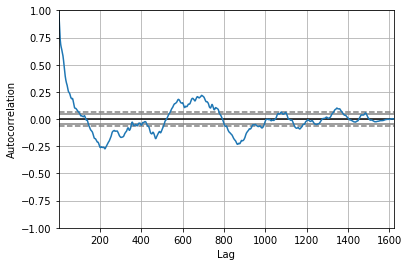

In [12]:
# autocorrelation plot of time series
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)
autocorrelation_plot(df)
pyplot.show()

In this plot, through its very nature of including correlations with large lag values, we can see interesting patterns.
Namely we can see that there is substantial negative correlation to the 200 day lag, which from a domain expertise 
standpoint tells us that this can express the cyclical, seasonal relationship between summer/winter.

The Statsmodels library also provides a version of the plot in the plot acf() function as a
line plot [http://statsmodels.sourceforge.net/devel/generated/statsmodels.graphics.tsaplots.plot_acf.html].

The following approach is to subsequently zoom further in, starting from the big picture with large lags and continuing on focusing on smaller lag sizes.

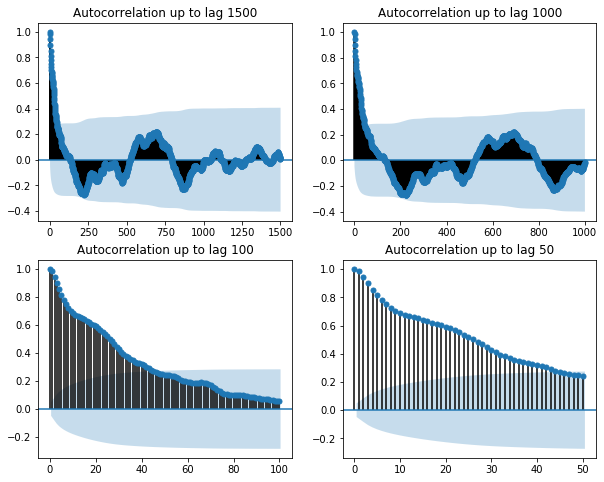

In [48]:
# autocorrelation plot of time series
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)

fig, axs = plt.subplots(2, 2, figsize=(10,8))

plot_acf(df, axs[0, 0], lags=1500)

plot_acf(df, axs[0, 1], lags=1000)

plot_acf(df, axs[1, 0], lags=100)
plot_acf(df, axs[1, 1], lags=50)

axs[0, 0].set_title('Autocorrelation up to lag 1500')
axs[0, 1].set_title('Autocorrelation up to lag 1000')
axs[1, 0].set_title('Autocorrelation up to lag 100')
axs[1, 1].set_title('Autocorrelation up to lag 50')

pyplot.show()

What we can see here clearly, especially in the upper row plots, is that there is some kind of seasonal pattern; although not 100% corresponding to the exact time the year before, the water level still seems to have some seasonal beahviour and can be brought into seasonal relationship with the seasons in the years before.

Furthermore, in the lower row plots we can see that there is significant correlation till up to a lag of about 50.

### Partial Autocorrelation

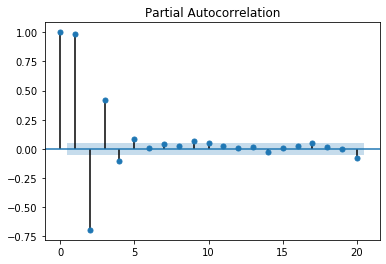

In [72]:
# PACF plot of time series
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

df = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)
plot_pacf(df, lags=20)
pyplot.show()

Here we can see significance up to a lag of 4 (or 5 respectively). Together with the observations made above (that the ACF is significant up to a lag of 50), this suggests an AR(4) model.
Furthermore, we are going to explore a SARIMA model because of the seasonality patterns observed above.

## 1.3. Persistence model

Let’s say that we want to develop a model to predict the last 7 days of the Rhine level
in the dataset given all prior observations. The simplest model that we could use to make
predictions would be to persist the last observation. We can call this a persistence model and
it provides a baseline of performance for the problem that we can use for comparison with an
autoregression model and more sophisticated methods like the CNN/RNN (LSTM) approach.

We can develop a test harness for the problem by splitting the observations into training
and test sets, with only the last 7 observations in the dataset assigned to the test set as unseen
data that we wish to predict. The predictions are made using a walk-forward validation model
so that we can persist the most recent observations for the next day. This means that we are
not making a 7-day forecast, but 7 1-day forecasts.

Test RMSE: 7.801


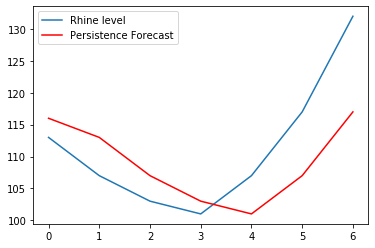

In [54]:
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)

# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

# plot predictions vs expected
pyplot.plot(test_y, label='Rhine level')
pyplot.plot(predictions, color='red', label='Persistence Forecast')
plt.legend(loc='upper left')
pyplot.show()

In the following this RMSE will be the one to outperform.

## 1.4. Autoregression Model

/export/home/kemeyer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


Coefficients: [ 3.54357599  1.97838529 -1.48776057  0.5831184  -0.09152288]
predicted=115.413336, expected=113.000000
predicted=118.354820, expected=107.000000
predicted=122.463543, expected=103.000000
predicted=126.422998, expected=101.000000
predicted=129.912457, expected=107.000000
predicted=133.051889, expected=117.000000
predicted=136.004203, expected=132.000000
Test RMSE: 16.727


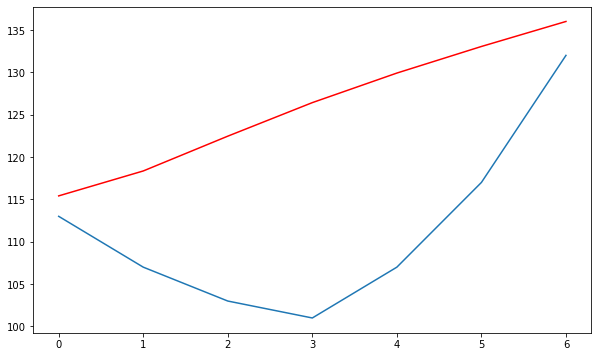

In [6]:
# create and evaluate a static autoregressive model
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

# load dataset
series = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)

# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=4)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red', label='predicted')
pyplot.show()

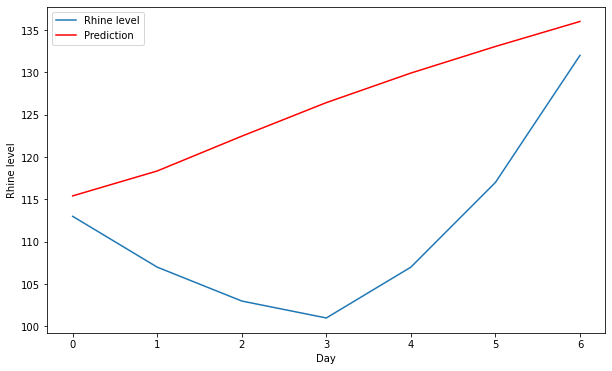

In [8]:
pyplot.plot(test)
pyplot.xlabel("Day")
pyplot.ylabel("Rhine level")
pyplot.plot(predictions, color='red', label='predicted')
pyplot.legend(["Rhine level", "Prediction"])
pyplot.show()

# 1.4 Autoregression model with 5 lags

/export/home/kemeyer/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


predicted=115.557686, expected=113.000000
predicted=113.730555, expected=107.000000
predicted=103.810331, expected=103.000000
predicted=103.653348, expected=101.000000
predicted=101.980026, expected=107.000000
predicted=115.337371, expected=117.000000
predicted=125.158762, expected=132.000000
Test RMSE: 4.380


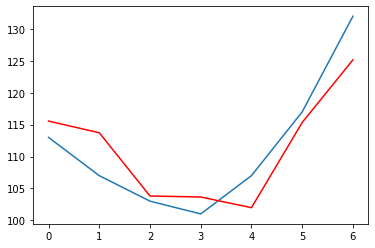

In [5]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)

# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
window = 5
model = AutoReg(train, lags=5)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

What we can see already is an increase in the performance over the persistance model; our assumptions of a lag of 5 being able to describe the behaviour well is thus plausible.

## 3. Convolutional Neural Networks

### 3.1. Bare metal CNN's

Convolutional Neural Network models, or CNNs for short, can be applied to time series
forecasting.

We will define a CNN with two convolutional layers for extracting features from the input sequences. Each will have a configurable number of filters and kernel size and will use the rectified linear
activation function. The number of filters determines the number of parallel fields on which the
weighted inputs are read and projected. The kernel size defines the number of time steps read
within each snapshot as the network reads along the input sequence

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
 > 14.527
 > 14.632
 > 16.649
 > 15.738
 > 15.763
 > 15.422
 > 16.532
 > 16.033
 > 14.904
 > 18.029
 > 14.577
 > 14.817
 > 14.294
 > 14.878
 > 15.459
 > 15.797
 > 15.336
 > 16.454
 > 14.930
 > 16.326
 > 16.157
 > 13.776
 > 14.401
 > 15.685
 > 15.530
 > 15.426
 > 14.606
 > 14.122
 > 15.312
 > 20.765
cnn-lstm: 15.563 RMSE (+/- 1.309)


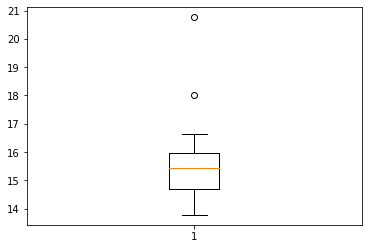

In [2]:
# evaluate cnn-lstm
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
import pandas as pd 

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)
data = series.values
# data split
n_test = 172
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

 > 4.491
 > 4.786
 > 3.941
 > 4.170
 > 7.692
 > 8.968
 > 4.887
 > 4.252
 > 6.057
 > 7.628
 > 4.676
 > 4.279
 > 7.882
 > 5.045
 > 4.618
 > 4.052
 > 4.206
 > 3.755
 > 4.122
 > 3.643
 > 3.861
 > 6.046
 > 4.240
 > 3.459
 > 5.191
 > 4.864
 > 5.438
 > 5.713
 > 6.246
 > 4.688
cnn-lstm: 5.097 RMSE (+/- 1.366)


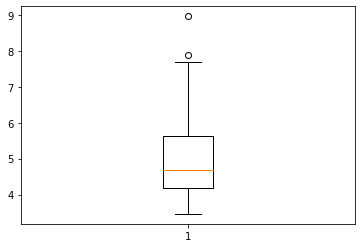

In [2]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
import pandas as pd 

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = pd.read_csv('basicDataset.txt', sep='\t', index_col=0, parse_dates=True, squeeze=True)
data = series.values
# data split
n_test = 7
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

We see that the CNN-LSTM model performs worse than the naive persistence model - disappointing, but still relevant to highlight that this type of neural network performs bad on the given problem.

## 3.2. ARIMA model manual configuration

<ipython-input-1-832a1e3bd468>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


                              ARMA Model Results                              
Dep. Variable:                  level   No. Observations:                 1620
Model:                     ARMA(4, 0)   Log Likelihood               -6364.743
Method:                       css-mle   S.D. of innovations             12.284
Date:                Sun, 07 Feb 2021   AIC                          12741.486
Time:                        15:30:53   BIC                          12773.827
Sample:                    01-01-2016   HQIC                         12753.488
                         - 06-07-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         196.5343     16.930     11.608      0.000     163.352     229.717
ar.L1.level     1.9782      0.025     79.999      0.000       1.930       2.027
ar.L2.level    -1.4870      0.053    -28.010    

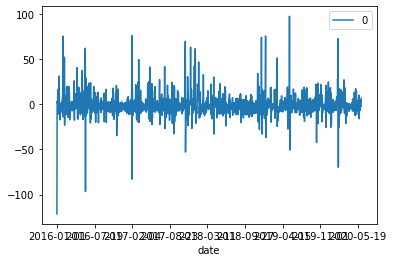

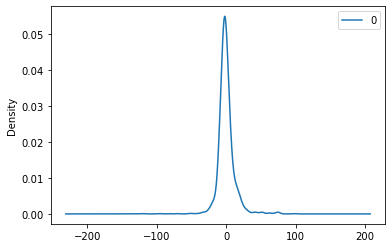

                 0
count  1620.000000
mean     -0.017388
std      12.648485
min    -121.534323
25%      -5.431681
50%      -1.248894
75%       3.791971
max      97.750615


In [1]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

# load dataset
series = read_csv('basicDataset.txt', sep='\t', header=0, index_col=0)

# fit model
model = ARIMA(series, order=(4,0,0))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print(residuals.describe())

The distribution of the residual errors is displayed. We see here that they are approximately Gaussian and there is only a small bias in the mean. This points into the direction that our model performs quite well. Let's further investigate the ARIMA(5, 1, 0) model.

predicted=161.213366, expected=155.000000
predicted=170.137687, expected=173.000000
predicted=176.952133, expected=157.000000
predicted=137.443680, expected=133.000000
predicted=119.468317, expected=136.000000
predicted=149.079567, expected=152.000000
predicted=164.538733, expected=169.000000
predicted=178.590336, expected=199.000000
predicted=221.146852, expected=194.000000
predicted=177.238696, expected=173.000000
predicted=157.849120, expected=156.000000
predicted=149.313462, expected=144.000000
predicted=139.228201, expected=128.000000
predicted=117.718529, expected=118.000000
predicted=115.705844, expected=113.000000
predicted=112.550874, expected=110.000000
predicted=109.727879, expected=116.000000
predicted=123.687595, expected=135.000000
predicted=150.940503, expected=161.000000
predicted=178.165948, expected=253.000000
predicted=329.993858, expected=328.000000
predicted=359.005450, expected=374.000000
predicted=389.360996, expected=380.000000
predicted=368.329994, expected=334

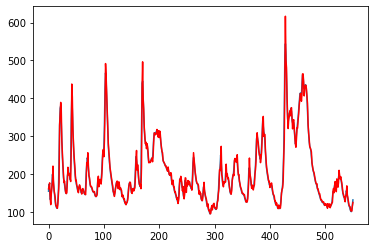

In [3]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# load dataset
series = read_csv('basicDataset.txt', sep='\t', header=0, index_col=0)

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(4,0,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Although we can see that the prediction is fairly close to the real data, we still have a RMSE which is bigger than the naive method.

## 3.3 ARIMA Grid Search

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('basicDataset.txt', sep='\t', header=0, index_col=0)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=83.056
ARIMA(0, 0, 1) RMSE=43.204
ARIMA(0, 1, 0) RMSE=20.580
ARIMA(0, 1, 1) RMSE=14.318
ARIMA(0, 1, 2) RMSE=13.152
ARIMA(0, 2, 0) RMSE=16.210
ARIMA(0, 2, 1) RMSE=15.250
ARIMA(0, 2, 2) RMSE=14.773
ARIMA(1, 0, 0) RMSE=20.475
ARIMA(1, 0, 2) RMSE=12.980
ARIMA(1, 1, 0) RMSE=14.915
ARIMA(1, 1, 1) RMSE=13.215
ARIMA(1, 1, 2) RMSE=13.089
ARIMA(1, 2, 0) RMSE=15.747
ARIMA(1, 2, 1) RMSE=14.936
ARIMA(2, 0, 0) RMSE=14.470
ARIMA(2, 0, 1) RMSE=12.940
ARIMA(2, 0, 2) RMSE=12.850
ARIMA(2, 1, 0) RMSE=13.052
ARIMA(2, 1, 1) RMSE=12.996
ARIMA(2, 1, 2) RMSE=12.909
ARIMA(2, 2, 0) RMSE=14.677
ARIMA(2, 2, 1) RMSE=13.069
ARIMA(4, 0, 0) RMSE=12.837
ARIMA(4, 0, 1) RMSE=12.801
ARIMA(4, 1, 0) RMSE=12.944
ARIMA(4, 1, 1) RMSE=12.913
ARIMA(4, 2, 0) RMSE=14.326
